# Generate Phase-only Hologram (Gerchberg-Saxton Algorithm)
 
- Reference
1. <i>P. M. Hirsch, J. J. A. Jordan, and L. B. Lesem, "Method of making an object-dependent diffuser", U.S. patent 3,619,022 (1971).</i>
2. <i>Ralph W. Gerchberg. 1972. "A practical algorithm for the determination of the phase from image and diffraction plane pictures". Optik 35 (1972), 237–246.</i>
3. <i>Poon T C, and Liu J P (2014) "Introduction to Modern Digital Holography with MATLAB", (Cambridge University Press, New York).</i>

(3번 Reference에 관해서는 "VML-2022 > [Hologram] > 0.Book > (Book) 2014 Poon&Liu Introduction to Modern Digital Holography With Matlab.pdf > 7.3 Iterative Fourier transform algorithm" 참고)

<br/>

#### <b>Gerchberg-Saxton Algorithm</b>
Kinoform hologram의 회절 효율은 매우 뛰어나지만, 재구성된 이미지는 보통 노이즈가 발생한다. 우리는 iterative Fourier transform algorithm (IFTA)을 소개하는데, 이는 <u>phase-only CGH를 최적화할 수 있다.</u> IFTA는 Hirsch et al. (Ref 1)에 의해 처음 제안되었다. 독립적으로, Gerchberg와 Saxton은 유사한 알고리즘을 사용하여 phase-retrieval problem를 다루었다 (Ref 2). 그래서 IFTA는 _Gerchberg-Saxton algorithm (GS algorithm)_이라고도 불린다.

PoH $H_p(x, y)$을 생성할 때, reconstruction 이미지의 진폭은 원하는 진폭 분포 $A(x, y)$에 비례해야 하며, 즉 아래와 같이 표현할 수 있다.

<center>
$F[H_p(x, y)] = F[e^{-j\phi(x, y)}] = A(x, y) e^{-j\theta(x, y)}$

</center>
여기서 $\phi(x, y)$는 홀로그램의 위상이고, $\theta(x, y)$는 reconstruct된 빛의 위상이다. phase-only CGH를 설계할 때는 $H_p$가 phase-only function이 되도록 하는 phase function $\theta(x, y)$를 찾아야 한다. 이 개념에 기반하여, IFTA는 $\theta(x, y)$의 최적 해를 찾기 위한 알고리즘이다.

<br/>

#### <b>Flowchart of GS-algorithm</b>
Gerchberg-Saxton (GS) 알고리즘은 phase distribution을 최적화하기 위해 널리 사용되는 반복 알고리즘으로, Fig 1에 나타난 것처럼 작동한다. 이 iteration은 object plane과 holographic plane 사이에서 하나의 순방향 FT와 하나의 역방향 FT(wavefront propagation)를 포함한다. holographic plane의 phase distribution는 두 평면의 amplitude constraint에 의해 점진적으로 최적화된다.

<center>
<p>
    <img src="gs-algorithm.png" width=100>
    
    Fig 1. Flowchart of GS-algorithm
</p>
</center>

1. Hologram plane에서 초기 랜덤 위상 $e^{i\phi_0}$을 생성한 후, image plane으로 전파한다.
2. Image plane으로 전파되어 복원된 이미지 $\hat{X}$과 Target image $X$를 RMSE로 비교한다.
3. 위상 $\theta$는 바꾸지 않은 상태로 image plane의 진폭 $\hat{X}$을 target image $X$로 제한한다.
4. Image plane의 target field $Xe^{i\theta}$를 hologram plane으로 전파한다.
5. Hologram plane으로 전파된 complex hologram으로부터 진폭을 1로 제한하여 위상 홀로그램을 얻을 수 있다.
6. 2-5 까지의 과정을 반복하여 위상 홀로그램을 반복-최적화 한다.
 



In [1]:
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
from time import time
cm, mm, um, nm = 1e-2, 1e-3, 1e-6, 1e-9

In [2]:
def pad_image(field, target_shape, padval=0, mode='constant'):
    """
        Pads a 2D complex field up to target_shape in size
        Padding is done such that when used with crop_image(), odd and even dimensions are handled correctly to properly undo the padding.

        field:          the field to be padded. May have as many leading dimensions as necessary (e.g., batch or channel dimensions)
        target_shape:   the 2D target output dimensions. If any dimensions are smaller than field, no padding is applied
        padval:         the real number value to pad by (default: 0)
        mode:           padding mode for numpy or torch
    """
    size_diff = np.array(target_shape) - np.array(field.shape[-2:])
    odd_dim = np.array(field.shape[-2:]) % 2

    # pad the dimensions that need to increase in size
    if (size_diff > 0).any():
        pad_total = np.maximum(size_diff, 0)
        pad_front = (pad_total + odd_dim) // 2
        pad_end = (pad_total + 1 - odd_dim) // 2

        leading_dims = field.ndim - 2  # only pad the last two dims
        if leading_dims > 0:
            pad_front = np.concatenate(([0] * leading_dims, pad_front))
            pad_end = np.concatenate(([0] * leading_dims, pad_end))
        return np.pad(field, tuple(zip(pad_front, pad_end)), mode, constant_values=padval)

    else:
        return field

In [3]:

def crop_image(field, target_shape):
    """
        Crops a 2D field, see pad_image() for detail
        No cropping is done if target_shape is already smaller than field
    """
    if target_shape is None:
        return field

    size_diff = np.array(field.shape[-2:]) - np.array(target_shape)
    odd_dim = np.array(field.shape[-2:]) % 2

    # crop dimensions that need to decrease in size
    if (size_diff > 0).any():
        crop_total = np.maximum(size_diff, 0)
        crop_front = (crop_total + 1 - odd_dim) // 2
        crop_end = (crop_total + odd_dim) // 2

        crop_slices = [slice(int(f), int(-e) if e else None) for f, e in zip(crop_front, crop_end)]
        return field[(..., *crop_slices)]
    else:
        return field

# 1. Make aperture at image plane (z=0)

$z_0$ 위치에서 Source plane (aperture) 생성. 이때, 단순한 binary 함수가 아닌, 다음의 수식을 통해 aperture를 생성한다.

$g(x, y;z_0)=\exp^{[-(\frac{\sqrt{x^2+y^2}}{D/2})^{50}]}$.

Source plane에서 $x$축, $y$축에 대한 표본화 간격 및 표본화 개수는 각각 10㎛, 1000을 따르며, aperture의 크기 $D=1$㎜로 설정한다.

- sampling interval: 10㎛
- the # of sample points: 1000
- source plane size: 10㎛ * 1000 = 10㎜
- aperture size: 1㎜


In [4]:
def source_field(image_size, aperture_size, sampling_interval, num_samples):

    # Grid Coordinate
    x_point = np.linspace(-image_size/2, image_size/2 - sampling_interval, num=num_samples)
    y_point = np.linspace(-image_size/2, image_size/2 - sampling_interval, num=num_samples)
    grid_x, grid_y = np.meshgrid(x_point, y_point)

    # Aperture
    aperture = np.sqrt((grid_x ** 2) + (grid_y ** 2)) / (aperture_size / 2)
    aperture = np.exp(-np.power(aperture, 50))
    return aperture

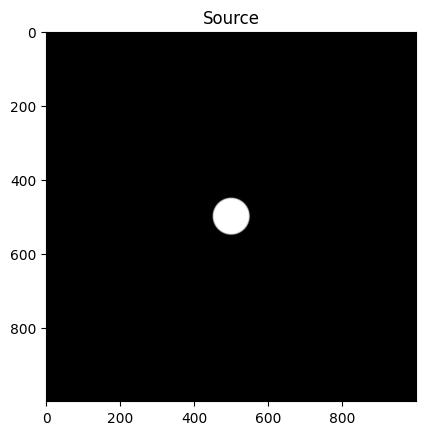

In [5]:
num_samples = 1000
sampling_interval = 10 * um
image_size = num_samples * sampling_interval
aperture_size = 1 * mm

# Make aperture at image plane (z=0)
source = source_field(image_size, aperture_size, sampling_interval, num_samples)

plt.imshow(source, cmap="gray")
plt.title("Source")
plt.show()

# 2. Band-limited Angular Spectrum Method (BL-ASM)

Band-Limited Angular Spectrum Method를 통해 $z_0$에 위치한 source를 $d$만큼 떨어진 거리의 destination field로 전파하는 방법은 다음과 같다.

$g[m, n; z] = FFT^{-1}[FFT[g[m, n; z_0]] \times H_{BLAS}[p, q; d]]$

1. $z_0$에 위치한 Image domain의 source plane을 Fourier Transform 한다.
2. Fourier domain에서 source plane을 $d$만큼 전파할 Transfer function (kernel)을 계산한다.
3. 1의 결과와 2의 결과를 곱한다. (Convolution in image domain)
4. 3의 결과에 inverse Fourier Transform 연산을 수행한다.


이때, Fourier domain에서의 transfer function $H$는 다음과 같이 계산할 수 있다.

$H_{BLAS}[p, q; d] = \begin{cases} \exp[i2\pi d(\lambda^{-2}-u_p^2-v_q^2)] rect(\frac{u_p}{2u_{BL}})rect(\frac{v_q}{2v_{BL}}) &\text{if } u_p^2+v_q^2\le\lambda^{-2}\\ 0 & \text{otherwise}  \end{cases}$



In [6]:
def propagation_blasm(u_in, feature_size, wave_length, z, linear_conv=True,
                      return_kernel=False, precomputed_kernel=None):
    """
        Propagates the input field using the angular spectrum method

        Inputs
        ------
        u_in:           input complex numpy array 
        feature_size:   (height, width) of individual holographic features in m
        wavelength:     wavelength in m
        z:              propagation distance
        linear_conv:    if True, pad the input to obtain a linear convolution, default True

        Output
        ------
        tensor of size (height, width)
    """

    # preprocess with (zero-)padding for linear convolution
    if linear_conv:
        input_resolution = u_in.shape[-2:]
        conv_size = [i * 2 for i in input_resolution]
        u_in = pad_image(u_in, conv_size, padval=0)

    if precomputed_kernel is None:
        field_resolution = u_in.shape[-2:]                          # Resolution of input field
        num_y, num_x = field_resolution[-2], field_resolution[-1]   # Number of pixels
        dy, dx = feature_size                                       # Sampling interval
        y, x = (dy * float(num_y), dx * float(num_x))               # Size of the input / slm field

        # frequency coordinates sampling
        fy = np.linspace(-1 / (2 * dy), 1 / (2 * dy), num_y)
        fx = np.linspace(-1 / (2 * dx), 1 / (2 * dx), num_x)
        fxx, fyy = np.meshgrid(fx, fy)

        # calculate transfer function (ASM)
        kernel = np.exp(1j * 2 * np.pi * z * np.sqrt(1 / wave_length**2 - (fxx**2 + fyy**2)))

        # calculate band-limited transfer function (BL-ASM)
        dv, du = 1 / (num_y * dy), 1 / (num_x * dx)
        bly = 1 / (wave_length * np.sqrt((2 * z * dv)**2 + 1))
        blx = 1 / (wave_length * np.sqrt((2 * z * du)**2 + 1))
        bl_filter = (np.abs(fxx) < blx) & (np.abs(fyy) < bly)
        bl_kernel = bl_filter * kernel

    else:
        bl_kernel = precomputed_kernel

    if return_kernel:
        return kernel

    # propagate source (aperture) to destination field
    u_out = fft.fftshift(fft.fftn(fft.fftshift(u_in), axes=(-2, -1)))     
    u_out = bl_kernel * u_out                                             
    u_out = fft.fftshift(fft.ifftn(fft.fftshift(u_out), axes=(-2, -1)))   
    
    if linear_conv:
        u_out = crop_image(u_out, input_resolution)

    return u_out

# 3. Make Full Complex Hologram
앞서 정의한 Propagation method를 통해 $d$만큼 떨어진 위치에서 complex hologram을 계산한다.

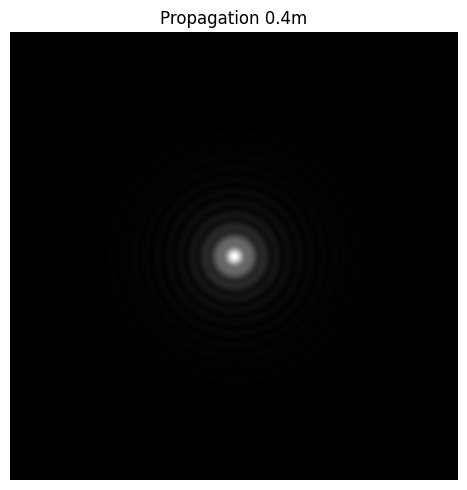

In [7]:
# fixed
source = source * np.exp(1j * np.zeros_like(source))
feature_size = (10 * um, 10 * um)

# experiment
wave_length = 633 * nm       
prop_dist = [40 * cm]
visualization_title = [f'Propagation {z}m' for z in prop_dist]

image_to_slm = []       # The list of full-complex hologram
for z in prop_dist:
    image_to_slm.append(
        propagation_blasm(source, feature_size, wave_length, z)
    )

plt.figure(figsize=(5, 5))
for i, hologram in enumerate(image_to_slm):
    plt.subplot(1, len(prop_dist), i + 1)
    plt.imshow(np.abs(hologram), cmap="gray")
    plt.title(visualization_title[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

# 4. Gerchberg-Saxton Algorithm (GS algorithm)


1. Hologram plane에서 초기 랜덤 위상 $e^{i\phi_0}$을 생성한 후, image plane으로 전파한다.
2. Image plane으로 전파되어 복원된 이미지 $\hat{X}$과 Target image $X$를 RMSE로 비교한다.
3. 위상 $\theta$는 바꾸지 않은 상태로 image plane의 진폭 $\hat{X}$을 target image $X$로 제한한다.
4. Image plane의 target field $Xe^{i\theta}$를 hologram plane으로 전파한다.
5. Hologram plane으로 전파된 complex hologram으로부터 진폭을 1로 제한하여 위상 홀로그램을 얻을 수 있다.
6. 2-5 까지의 과정을 반복하여 위상 홀로그램을 반복-최적화 한다.
 

In [8]:
def root_mean_square_error(target, output):
    return np.sqrt(np.mean((output - target) ** 2))

def gerchberg_saxton_algorithm(u_in, feature_size, wave_length, z, linear_conv=True, 
                               num_iters=500, save_poh_interval=25, seed=7777):
    np.random.seed(seed)
    
    # kernel from image plane to hologram plane
    precomputed_kernel_f = propagation_blasm(np.zeros_like(u_in), feature_size, wave_length, z, linear_conv, return_kernel=True)

    # kernel from hologram plane to image plane
    precomputed_kernel_b = propagation_blasm(np.zeros_like(u_in), feature_size, wave_length, -z, linear_conv, return_kernel=True)

    # Generate initial phase
    init_phase = np.random.rand(u_in.shape[-2], u_in.shape[-1])
    holo_field = np.exp(1j * 2 * np.pi * init_phase)

    # Run the GS algorithm
    errors = []
    gs_pohs = []
    start_time = time()
    for i in range(1, num_iters + 1):
        # Propagate Phase-only hologram from hologram plane to image plane
        recon_field = propagation_blasm(holo_field, feature_size, wave_length, -z, linear_conv, precomputed_kernel=precomputed_kernel_b)

        # Calculate RMSE
        recon = np.abs(recon_field)
        recon = (recon - np.amin(recon)) / (np.amax(recon) - np.amin(recon))
        error = root_mean_square_error(u_in, recon)

        # Replace amplitude to target image
        recon_field = u_in * np.exp(1j * np.angle(recon_field))

        # Propagate Target field from image plane to hologram plane
        holo_field = propagation_blasm(recon_field, feature_size, wave_length, z, linear_conv, precomputed_kernel=precomputed_kernel_f)

        # Amplitude constraint at the hologram plane
        holo_field = np.exp(1j * np.angle(holo_field))

        if i % save_poh_interval == 0:
            errors.append(error)
            gs_pohs.append(np.angle(holo_field))
            print(f'{i} iters RMSE: {error:.6f}, {(time() - start_time):.6f}s')

    return errors, gs_pohs

In [9]:
# Make aperture at image plane (z=0)
num_samples = 1000
sampling_interval = 10 * um
image_size = num_samples * sampling_interval
aperture_size = 1 * mm
source = source_field(image_size, aperture_size, sampling_interval, num_samples)

# fixed
feature_size = (sampling_interval, sampling_interval)

# experiment
wave_length = 633 * nm       
prop_dist = [40 * cm]
visualization_title = [f'Propagation {z}m' for z in prop_dist]

# Generate Phase-only hologram with gs-algorithm
num_iters = 500
save_poh_interval = 25
errors = []
gs_pohs = []

for z in prop_dist:
    result = gerchberg_saxton_algorithm(
        source, feature_size, wave_length, z, True,
        num_iters=num_iters, save_poh_interval=save_poh_interval
    )

    errors.append(result[0])
    gs_pohs.append(result[1])

25 iters RMSE: 0.045454, 19.546775s
50 iters RMSE: 0.045272, 44.454836s
75 iters RMSE: 0.044320, 72.343376s
100 iters RMSE: 0.043370, 99.990674s
125 iters RMSE: 0.042343, 127.620702s
150 iters RMSE: 0.042188, 155.304934s
175 iters RMSE: 0.042487, 183.311908s
200 iters RMSE: 0.042099, 211.060458s
225 iters RMSE: 0.041711, 238.826342s
250 iters RMSE: 0.041806, 265.540671s
275 iters RMSE: 0.042089, 292.582510s
300 iters RMSE: 0.042473, 320.001075s
325 iters RMSE: 0.042970, 347.475385s
350 iters RMSE: 0.044127, 375.006606s
375 iters RMSE: 0.044687, 402.382996s
400 iters RMSE: 0.045521, 429.812204s
425 iters RMSE: 0.045387, 457.164352s
450 iters RMSE: 0.044943, 484.642094s
475 iters RMSE: 0.043952, 512.029545s
500 iters RMSE: 0.043698, 539.652585s


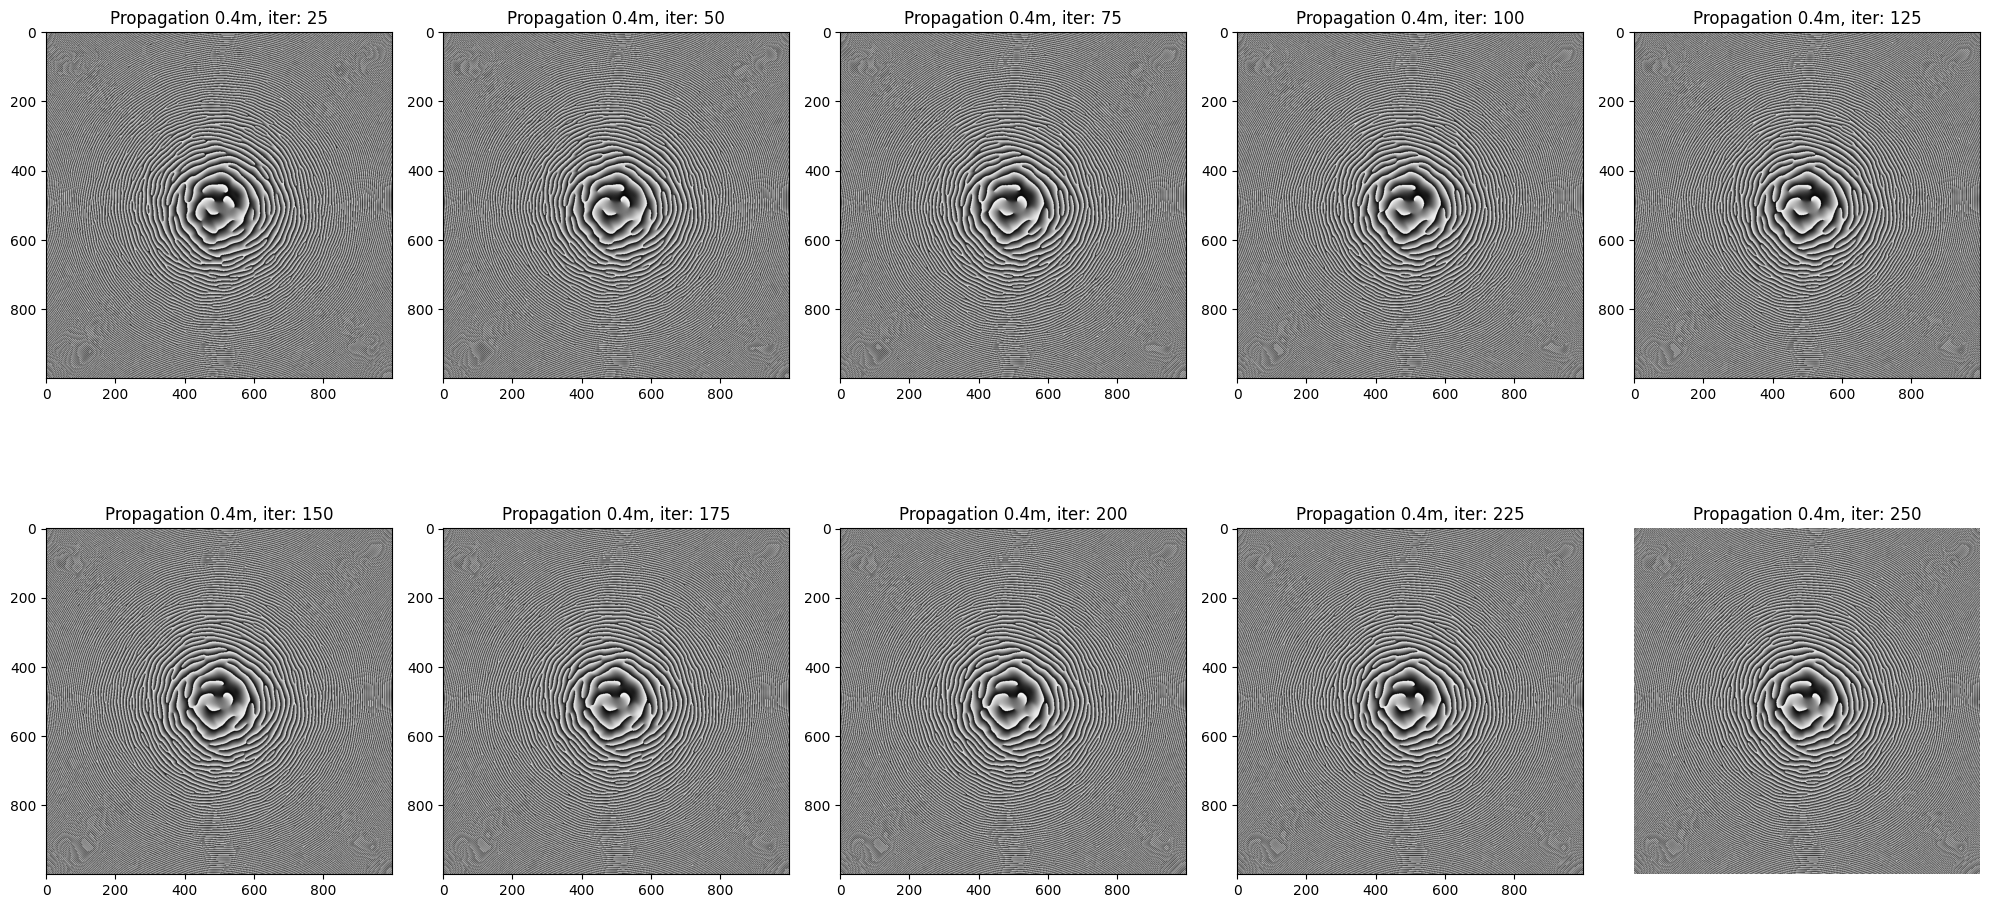

In [10]:
visualization_title = [
    f'Propagation {z}m, iter: {iteration * 25}' 
    for z in prop_dist 
    for iteration in range(1, 1 + len(gs_pohs[0]))
]

plt.figure(figsize=(20, 20))
for i, gs_poh in enumerate(gs_pohs[0][:10]):
    plt.subplot(4, 5, i + 1)
    plt.imshow(gs_poh, cmap="gray")
    plt.title(visualization_title[i])    

plt.axis('off')
plt.tight_layout()
plt.show()

# 5. Reconstruction

### 5-1. Visualize Numerical Reconstruction of Full-complex Hologram

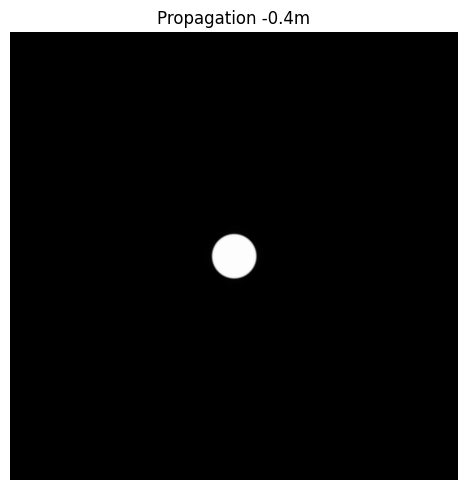

In [11]:
visualization_title = [f'Propagation -{z}m' for z in prop_dist]

slm_to_image_1 = []
for z, hologram in zip(prop_dist, image_to_slm):
    recon = propagation_blasm(hologram, feature_size, wave_length, -z)
    
    recon = np.abs(recon)
    recon = (recon - np.amin(recon)) / (np.amax(recon) - np.amin(recon))
    slm_to_image_1.append(recon)

plt.figure(figsize=(5, 5))
for i, image in enumerate(slm_to_image_1):
    plt.subplot(1, len(prop_dist), i + 1)
    plt.imshow(image, cmap="gray")
    plt.title(visualization_title[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

### 5-2. Visualize Numerical Reconstruction of Phase-only Hologram through GS algorithm

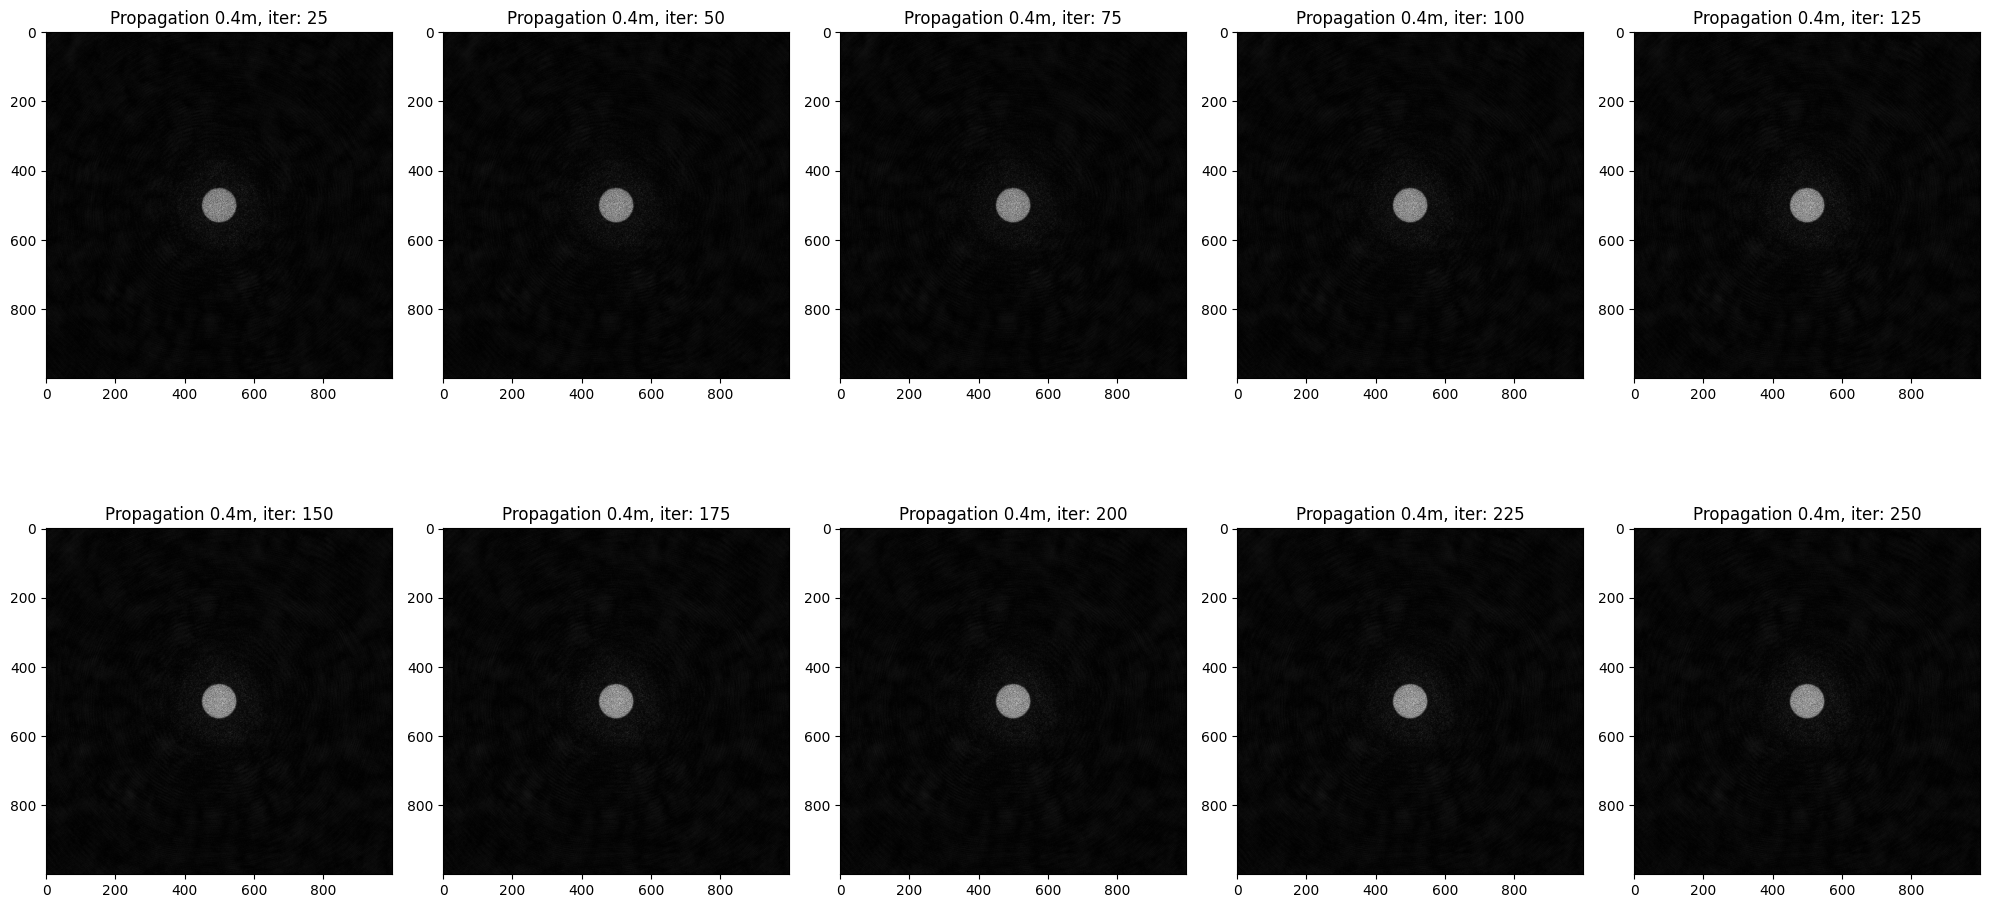

In [12]:
slm_to_image_2 = []
for gs_poh in gs_pohs[0]:
    recon = propagation_blasm(np.exp(1j * np.angle(gs_poh)), feature_size, wave_length, -prop_dist[0])

    recon = np.abs(recon)
    recon = (recon - np.amin(recon)) / (np.amax(recon) - np.amin(recon))
    slm_to_image_2.append(recon)

visualization_title = [
    f'Propagation {z}m, iter: {iteration * 25}' 
    for z in prop_dist 
    for iteration in range(1, 1 + len(gs_pohs[0]))
]

plt.figure(figsize=(20, 20))
for i, image in enumerate(slm_to_image_2[:10]):
    plt.subplot(4, 5, i + 1)
    plt.imshow(image, cmap="gray")
    plt.title(visualization_title[i])
plt.tight_layout()
plt.show()

# 6. Objective Quality Metrics


In [13]:
def peak_signal_noise_ratio(target, output):
    rmse = np.sqrt(np.mean((target - output) ** 2))
    psnr = 20 * np.log10(1.0 / rmse)
    return psnr

In [14]:
source = np.abs(source)

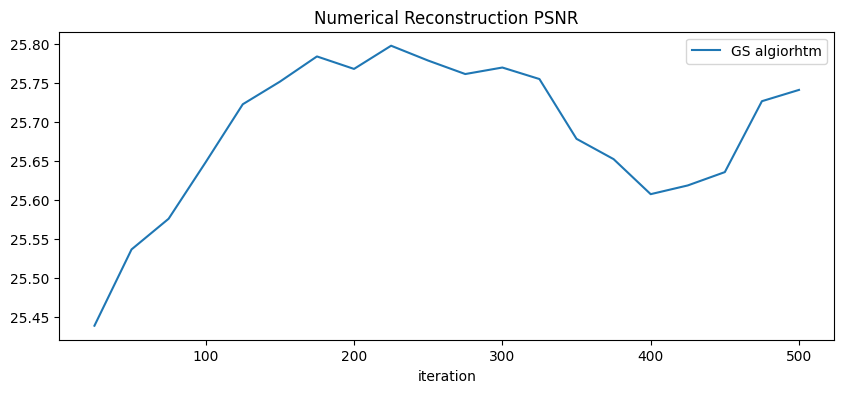

In [15]:
psnrs = []
for image in slm_to_image_2:
    psnrs.append([
        peak_signal_noise_ratio(source, image)
    ])

plt.figure(figsize=(10, 4))
plt.plot([iteration * 25 for iteration in range(1, 1 + len(gs_pohs[0]))], psnrs, label='GS algiorhtm')
plt.title('Numerical Reconstruction PSNR')
plt.xlabel('iteration')
plt.legend()
plt.show()

# 7. Discussion

# 8. 2D Image

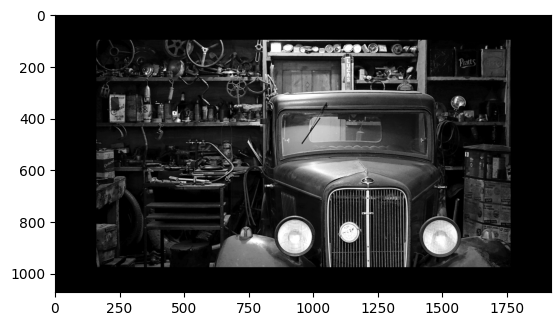

In [16]:
import skimage.io as sio
img = sio.imread('sample1.png')[:, :, 1] / 255.
plt.imshow(img, cmap='gray')
plt.show()

In [17]:
# fixed
img = sio.imread('sample1.png')[:, :, 1] / 255.
feature_size = (6.4 * um, 6.4 * um)

# experiment
wave_length = 530 * nm
prop_dist = [20 * cm]
visualization_title = [f'Propagation {z}m' for z in prop_dist]

# Generate Phase-only hologram with gs-algorithm
num_iters = 20
save_poh_interval = 2
errors = []
gs_pohs = []

for z in prop_dist:
    result = gerchberg_saxton_algorithm(
        img, feature_size, wave_length, z, True,
        num_iters=num_iters, save_poh_interval=save_poh_interval
    )

    errors.append(result[0])
    gs_pohs.append(result[1])

2 iters RMSE: 0.152508, 5.806858s
4 iters RMSE: 0.131385, 11.633821s
6 iters RMSE: 0.123800, 17.501003s
8 iters RMSE: 0.119988, 23.367740s
10 iters RMSE: 0.118944, 29.201558s
12 iters RMSE: 0.117063, 35.030532s
14 iters RMSE: 0.115676, 40.830565s
16 iters RMSE: 0.114658, 46.657949s
18 iters RMSE: 0.113487, 52.449422s
20 iters RMSE: 0.112500, 58.383931s


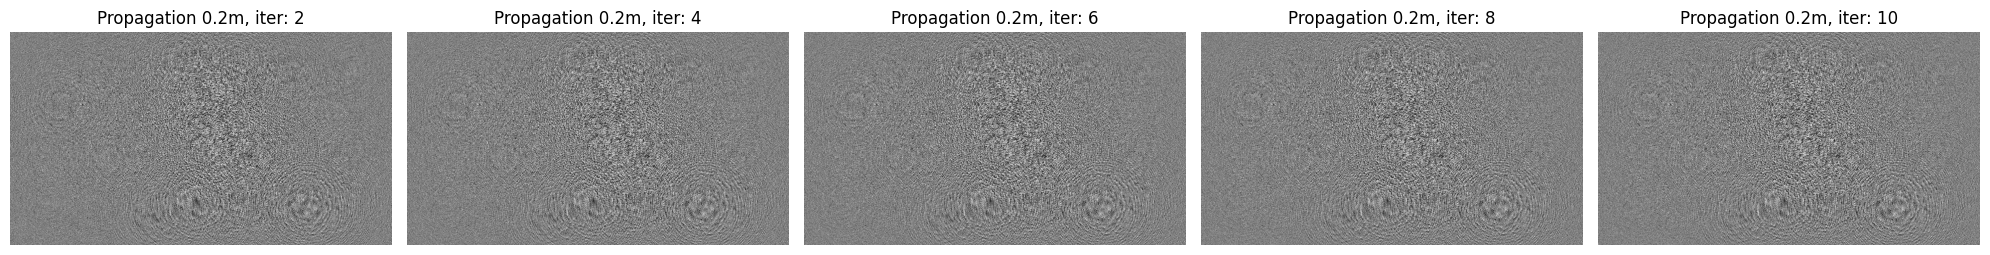

In [18]:
visualization_title = [ 
    f'Propagation {z}m, iter: {iteration * save_poh_interval}' 
    for z in prop_dist 
    for iteration in range(1, 1 + len(gs_pohs[0]))
]

plt.figure(figsize=(20, 20))
for i, gs_poh in enumerate(gs_pohs[0][:5]):
    plt.subplot(1, 5, i + 1)
    plt.imshow(gs_poh, cmap="gray")
    plt.title(visualization_title[i])    
    plt.axis('off')
    
plt.tight_layout()
plt.show()

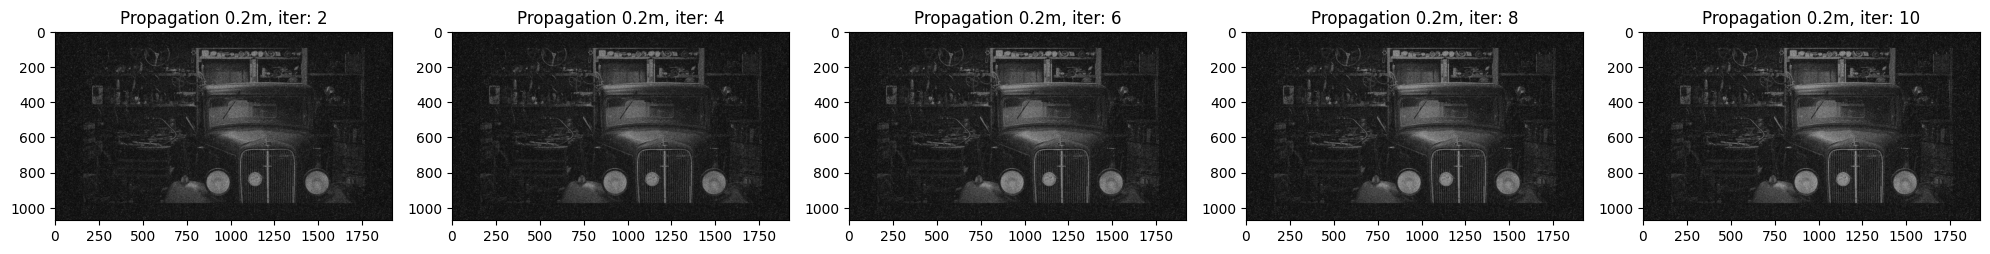

In [19]:
slm_to_image_2 = []
for gs_poh in gs_pohs[0]:
    recon = propagation_blasm(np.exp(1j * np.angle(gs_poh)), feature_size, wave_length, -prop_dist[0])

    recon = np.abs(recon)
    recon = (recon - np.amin(recon)) / (np.amax(recon) - np.amin(recon))
    slm_to_image_2.append(recon)

visualization_title = [
    f'Propagation {z}m, iter: {iteration * save_poh_interval}' 
    for z in prop_dist 
    for iteration in range(1, 1 + len(gs_pohs[0]))
]

plt.figure(figsize=(20, 20))
for i, image in enumerate(slm_to_image_2[:5]):
    plt.subplot(1, 5, i + 1)
    plt.imshow(image, cmap="gray")
    plt.title(visualization_title[i])
plt.tight_layout()
plt.show()

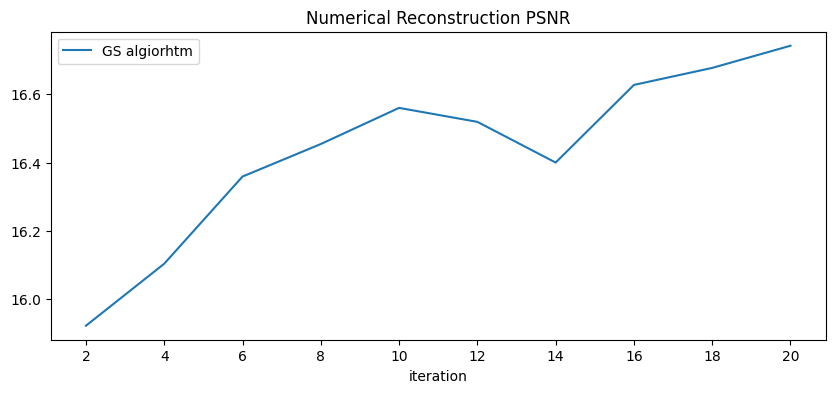

In [20]:
psnrs = []
for image in slm_to_image_2:
    psnrs.append([
        peak_signal_noise_ratio(img, image)
    ])

x = [iteration * save_poh_interval for iteration in range(1, 1 + len(gs_pohs[0]))]
plt.figure(figsize=(10, 4))
plt.plot(x, psnrs, label='GS algiorhtm')
plt.title('Numerical Reconstruction PSNR')
plt.xticks(x)
plt.xlabel('iteration')
plt.legend()
plt.show()